# Lab 3 — recommender systems

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [2]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [3]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

## 3.4 Basic Statistics

In [4]:
user_ratings = data.map(lambda d: (d['userId'], d['rating'])).collect()

In [5]:
ratings_per_user = data.map(lambda d: (d['userId'], d['rating'])).groupByKey().map(lambda d: len(d[1])).collect()

In [6]:
ratings_per_item = data.map(lambda d: (d['movieId'], d['rating'])).groupByKey().map(lambda d: len(d[1])).collect()

Text(0.5,1,'Histogram of how many items have how many ratings')

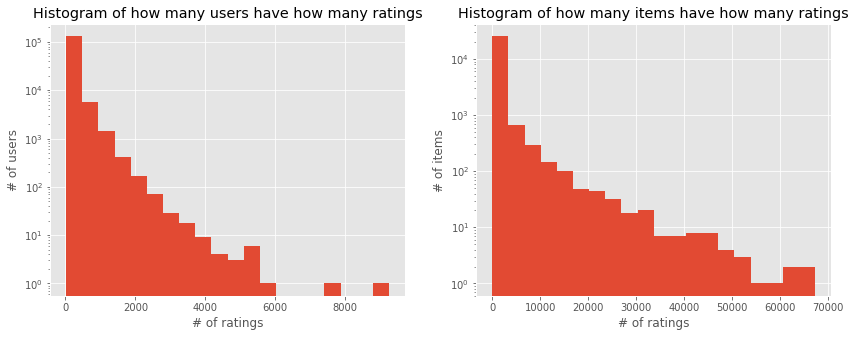

In [7]:
plt.figure(num=None, figsize=(14, 5))

plt.subplot(1,2,1)
plt.hist(ratings_per_user, bins=20, log=True)
plt.xlabel("# of ratings")
plt.ylabel("# of users")
plt.title("Histogram of how many users have how many ratings")

plt.subplot(1,2,2)
plt.hist(ratings_per_item, bins=20, log=True)
plt.xlabel("# of ratings")
plt.ylabel("# of items")
plt.title("Histogram of how many items have how many ratings")

The number of ratings are clearly not balanced uniformly, since many users/items have almost no ratings, while others have a lot.

In [8]:
with open('my-ratings.txt') as f:
    my_ratings = sc.parallelize([json.loads(line) for line in f.read().splitlines()])

In [9]:
data = data.union(my_ratings)

In [10]:
training = data.filter(lambda x: (x['timestamp'] % 10) > 1).map(lambda x: (x['userId'], x['movieId'], x['rating'])).persist()
validation = data.map(lambda x: (x['userId'], x['movieId'], x['rating'])).subtract(training).persist()

In [11]:
global_mean = training.map(lambda x: x[2]).reduce(lambda x, y: x + y)
global_mean /= training.count()

In [12]:
user_bias = training.map(lambda x: (x[0], x[2])).groupByKey().map(lambda x: (x[0], 0 if sum(x[1]) == 0 else sum(x[1])/len(x[1]) - global_mean))

In [37]:
u_b_local = dict(user_bias.collect())

In [14]:
item_bias = training.map(lambda x: (x[1], x[2] - u_b_local[x[0]])).groupByKey().map(lambda x: (x[0], 0 if sum(x[1]) == 0 else sum(x[1])/len(x[1]) - global_mean))

In [15]:
i_b_local = dict(item_bias.collect())

In [41]:
sq_err_per_user = validation.map(lambda x: (x[0], (x[2] - global_mean - u_b_local.get(x[0], 0) - i_b_local.get(x[1], 0))**2)).groupByKey()

In [43]:
mean_err = sq_err_per_user.map(lambda x: (sum(x[1])/len(x[1]), 1)).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))

In [46]:
mean_err[0]/mean_err[1]

0.854779985790904